In [1]:
'''
TODO:
1. CLEAN locality data (remove others) - Done
2. CLEAN lighting (remove Dusk/Dawn?) - Done
3. CLEAN surfaceCondition(remove others) - Done
4. CLEAN weather (remove Others and cloudy) - Done
5. CLEAN seatBelt(remove Unknown) - done
6. CLEAN age (remove unknown) - done
7. CLEAN gender (remove unknown) - done
8. What to do with Behavior
9. What to do with Distraction
10. Add embedding layer with vectors in 2 dimension
'''

'\nTODO:\n1. CLEAN locality data (remove others) - Done\n2. CLEAN lighting (remove Dusk/Dawn?) - Done\n3. CLEAN surfaceCondition(remove others) - Done\n4. CLEAN weather (remove Others and cloudy) - Done\n5. CLEAN seatBelt(remove Unknown) - done\n6. CLEAN age (remove unknown) - done\n7. CLEAN gender (remove unknown) - done\n8. What to do with Behavior\n9. What to do with Distraction\n10. Add embedding layer with vectors in 2 dimension\n'

In [2]:
# from Ipython.core.interactiveshell import interactiveShell
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.utils.np_utils import to_categorical
from keras import backend as K
import keras
import numpy as np
import ast
# from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import pandas as pd
import seaborn as sn
import random
random.seed(1234)

/home/vincent/virtualenvironment/markov/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# InteractiveShell.ast_node_interactivity = 'all'

In [4]:
# Hyperparameters
batch_size = 8
time_steps = 61
data_dim = 1
test_split = 0.1
validation_split = 0.1
num_epoch = 30

In [5]:
# Convert json data to dictionary
with open('baseline_data.json') as f:
    data = f.read()
    data_dict_ = ast.literal_eval(data)

In [6]:
# Remove data with less than 61 states
for i in range(4950):
    if len(data_dict_['glance_sequence'][str(i)]) != 61:
        print(i)
        for key in data_dict_.keys():
            data_dict_[key].pop(str(i))

289
506
909
1203
1510
1788
2242
2505
2603
3426
3595
3674
3799
3853
4671


In [7]:
data_dict = {}
for key in data_dict_.keys():
#     data_dict_train[key] = np.array([],dtype=np.int32)
#     data_dict_test[key] = np.array([],dtype=np.int32)
    data_dict[key] = []


# Convert dictionary with index as key into an array
for i in sorted(map(int,data_dict_['id'].keys())): 
    # Traverse through all data columns/keys
    for key in data_dict_.keys():
        # Get the data from the inner dict with the str index as key and append it in order
        data_dict[key].append(data_dict_[key][str(i)])

In [43]:
counter = 0
for count,sequence in enumerate(data_dict['glance_sequence']):
    if 6 in sequence:
        counter+=1
#         print count
print 'Count:{}'.format(counter)

Count:4914


In [8]:
def cleanData(data_dict, name):
    '''
    return:
        [test_x,test_y],[train_x,train_y]
    '''
    if name == 'proximity_to_an_intersection': # Just split the data accordingly
        glances = data_dict['glance_sequence'] 
        labels = data_dict['proximity_to_an_intersection']
        split = int(test_split*len(labels))
        return [glances[:split],labels[:split]],[glances[split:],labels[split:]]
    elif name == 'lighting':
        cleanedData = []
        glances = data_dict['glance_sequence']
        labels = data_dict['lighting']
        to_keep = [i for i,e in enumerate(labels) if e != 3]
        for i in to_keep:
            cleanedData.append((glances[i],labels[i]))
        random.shuffle(cleanedData)
        split = int(test_split*len(cleanedData))
        return [list(a) for a in zip(*cleanedData[:split])], [list(a) for a in zip(*cleanedData[split:])]
    elif name == 'trafficControl': # Just split the data accordingly
        glances = data_dict['glance_sequence'] 
        labels = data_dict['trafficControl']
        split = int(test_split*len(labels))
        return [glances[:split],labels[:split]],[glances[split:],labels[split:]]        
    elif name == 'locality':
        cleanedData = []
        glances = data_dict['glance_sequence']
        labels = data_dict['locality']
        to_keep = [i for i,e in enumerate(labels) if e != 4] # Get index that doesn't need to be removed
        for i in to_keep:
            cleanedData.append((glances[i],labels[i]))
        random.shuffle(cleanedData)
        split = int(test_split*len(cleanedData))
        return [list(a) for a in zip(*cleanedData[:split])], [list(a) for a in zip(*cleanedData[split:])] # Test, Train
    elif name == 'trafficDensity': # Just split the data accordingly
        glances = data_dict['glance_sequence'] 
        labels = data_dict['trafficDensity']
        split = int(test_split*len(labels))
        return [glances[:split],labels[:split]],[glances[split:],labels[split:]]  
    elif name == 'surfaceCondition':
        cleanedData = []
        glances = data_dict['glance_sequence']
        labels = data_dict['surfaceCondition']
        to_keep = [i for i,e in enumerate(labels) if e != 2] # Get index that doesn't need to be removed
        for i in to_keep:
            cleanedData.append((glances[i],labels[i]))
        random.shuffle(cleanedData)
        split = int(test_split*len(cleanedData))
        return [list(a) for a in zip(*cleanedData[:split])], [list(a) for a in zip(*cleanedData[split:])] # Test, Train
    elif name == 'weather':
        cleanedData = []
        glances = data_dict['glance_sequence']
        labels = data_dict['weather']
        to_keep = [i for i,e in enumerate(labels) if e != 3 and e != 2] # Get index that doesn't need to be removed
        for i in to_keep:
            cleanedData.append((glances[i],labels[i]))
        random.shuffle(cleanedData)
        split = int(test_split*len(cleanedData))
        return [list(a) for a in zip(*cleanedData[:split])], [list(a) for a in zip(*cleanedData[split:])] # Test, Train
    elif name == 'alignment': # Just split the data accordingly
        glances = data_dict['glance_sequence'] 
        labels = data_dict['alignment']
        split = int(test_split*len(labels))
        return [glances[:split],labels[:split]],[glances[split:],labels[split:]] 
    elif name == 'travelLanes': # Just split the data accordingly
        glances = data_dict['glance_sequence'] 
        labels = data_dict['travelLanes']
        split = int(test_split*len(labels))
        return [glances[:split],labels[:split]],[glances[split:],labels[split:]]
    elif name == 'trafficDivider': # Just split the data accordingly
        glances = data_dict['glance_sequence'] 
        labels = data_dict['trafficDivider']
        split = int(test_split*len(labels))
        return [glances[:split],labels[:split]],[glances[split:],labels[split:]]
    elif name == 'seatBelt':
        cleanedData = []
        glances = data_dict['glance_sequence']
        labels = data_dict['seatBelt']
        to_keep = [i for i,e in enumerate(labels) if e != 2] # Get index that doesn't need to be removed
        for i in to_keep:
            cleanedData.append((glances[i],labels[i]))
        random.shuffle(cleanedData)
        split = int(test_split*len(cleanedData))
        return [list(a) for a in zip(*cleanedData[:split])], [list(a) for a in zip(*cleanedData[split:])] # Test, Train
    elif name == 'age':
        cleanedData = []
        glances = data_dict['glance_sequence']
        labels = data_dict['age']
        to_keep = [i for i,e in enumerate(labels) if e != 3] # Get index that doesn't need to be removed
        for i in to_keep:
            cleanedData.append((glances[i],labels[i]))
        random.shuffle(cleanedData)
        split = int(test_split*len(cleanedData))
        return [list(a) for a in zip(*cleanedData[:split])], [list(a) for a in zip(*cleanedData[split:])] # Test, Train
    elif name == 'gender':
        cleanedData = []
        glances = data_dict['glance_sequence']
        labels = data_dict['gender']
        to_keep = [i for i,e in enumerate(labels) if e != 2] # Get index that doesn't need to be removed
        for i in to_keep:
            cleanedData.append((glances[i],labels[i]))
        random.shuffle(cleanedData)
        split = int(test_split*len(cleanedData))
        print split
        return [list(a) for a in zip(*cleanedData[:split])], [list(a) for a in zip(*cleanedData[split:])] # Test, Train
    else:
        print 'Error'

In [9]:
# count = 0
# for i in data_dict['gender']:
#     if i == 2:
#         count += 1
# print count

In [10]:
xy = []
# xy.append([cleanData(data_dict,'proximity_to_an_intersection'),'proximity_to_an_interesection',2])
xy.append([cleanData(data_dict,'lighting'),'lighting',3])
# xy.append([cleanData(data_dict,'trafficControl'),'trafficControl',2])
xy.append([cleanData(data_dict,'locality'),'locality',4])
xy.append([cleanData(data_dict,'trafficDensity'),'trafficDensity',3])
# xy.append([cleanData(data_dict,'surfaceCondition'),'surfaceCondition',2])
# xy.append([cleanData(data_dict,'weather'),'weather',2])
# xy.append([cleanData(data_dict,'alignment'),'alignment',2])
# xy.append([cleanData(data_dict,'travelLanes'),'travelLanes',2])
# xy.append([cleanData(data_dict,'trafficDivider'),'trafficDivider',2])
# xy.append([cleanData(data_dict,'seatBelt'),'seatBelt',2])
xy.append([cleanData(data_dict,'age'),'age',3])
# xy.append([cleanData(data_dict,'gender'),'gender',2])

In [11]:
def balanceDataset(x_data, y_data, num_of_class):
    '''
    @args:
        x_data: glance sequence
        y_data: label with values from 0 to n
        num_of_class: num of types of label
    Balance the dataset by oversampling classes with smaller dataset
    In the resulting dataset, each class has size equal to the class with the largest dataset
    '''
    # Array with one inner array for each class
    x_train = [[] for i in range(num_of_class)]
    y_train = [[] for i in range(num_of_class)]
    
    # Allocate data according to class
    for i,y in enumerate(y_data):
        x_train[y].append(x_data[i])
        y_train[y].append(y_data[i])
        
    # Get largest class size
    size = max(map(len,y_train))

    # slice_at = int(0.9*len(y_train))
    
    # Oversample smaller classes randomly
    count = 0
    for x,y in zip(x_train,y_train):
        print 'Added {} data to {}'.format(size - len(y),count)
        for i in range(size - len(y)):
            num = random.randint(0,len(y)-1)
            x_data.append(x[num])
            y_data.append(y[num])
        count += 1
    
    # Shuffle data before returning to spread the dataset
    shuffles = zip(x_data,y_data)
    random.shuffle(shuffles)
    x_data,y_data = zip(*shuffles)

    return x_data,y_data

In [12]:
def train(x_train_np, y_train_np, x_test_np, y_test_np, loss, metrics, balance_weight, name, num_of_class):
    '''
    @args:
        x_train_np: train glance sequence (numpy array)
        y_train_np: train label (numpy array)
        x_test_np: test glance sequence (numpy array)
        y_test_np: test label (numpy array)
        loss: loss function
        metrics: metrics for accuracy
        class_weight: Should class_weight balancing be done
    '''
    K.clear_session()
    rmsprop = keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
#     adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
    model = Sequential()
#     model.add(keras.layers.SimpleRNN(128,input_shape=(time_steps,data_dim)))
    model.add(LSTM(128, dropout=0.0, recurrent_dropout=0.0, input_shape=(time_steps,data_dim), ))
    model.add(Dense(num_of_class, activation='softmax'))
    model.compile(loss=loss,
                  optimizer=rmsprop,
#                  optimizer=adam,
                 metrics=[metrics])

    print('Train...')
    if balance_weight:
        cw = class_weight.compute_class_weight('balanced', np.unique(y_train_np),y_train_np)
        cw_dict = dict(enumerate(cw))
    else:
        cw_dict = None
    
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, mode='auto')
    reduce_LR_on_plateau = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, mode='auto')
    model_checkpoint = keras.callbacks.ModelCheckpoint("checkpoint_{}".format(name), monitor="val_categorical_accuracy", 
                                                       save_best_only=True, mode='auto')
    tensorboard = keras.callbacks.TensorBoard(log_dir='./tb_logs/{}/'.format(name), histogram_freq=1, write_graph=True, 
                                              write_grads=True, write_images=False)
    model.fit(x_train_np, y_train_np,
             batch_size=batch_size,
             epochs=num_epoch,
             validation_split=validation_split,
             class_weight=cw_dict,
             callbacks = [early_stopping,reduce_LR_on_plateau,model_checkpoint,tensorboard],
             verbose=2)

    predictions_ = model.predict(np.array(x_test_np),batch_size=batch_size)
    predictions = []
    try:
        for pred in predictions_:
            predictions.append(np.argmax(pred))
    except:
        print "Something wrong at predictions yo"
    cm = confusion_matrix(y_test_np,predictions)
    axis_index = range(num_of_class)
    axis_predicted = ['Predicted {}'.format(a_i) for a_i in axis_index]
    df_cm = pd.DataFrame(cm, index = axis_index, columns = axis_predicted)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm,annot=True,cmap='Blues', fmt='g')
    acc = [cm[i][i] for i in range(num_of_class)]
    print("accuracy:" ,sum(acc)/float(len(y_test_np)))

    score, acc = model.evaluate(x_test_np, y_test_np,
                              batch_size=batch_size)
    print('Test score:', score)
    print('Test accuracy:', acc)
    return model

In [13]:
def trainAll(xy):
    models = []
    for xy_ in xy:
        trains = xy_[0][1]
        tests = xy_[0][0]
        num_of_class = xy_[2]
        name = xy_[1]
#         x_train, y_train = balanceDataset(trains[0],trains[1],num_of_class)
        x_train, y_train = trains[0], trains[1]
        x_test, y_test = tests[0],tests[1]
        x_train, y_train, x_test, y_test = map(np.array,(x_train,y_train,x_test,y_test))
        x_train = x_train.reshape(-1,61,1)
        x_test = x_test.reshape(-1,61,1)
        print y_train[:-800]
        print y_train[-800:]
        for i in range(10):
            print x_train[i]
        # Dummy Test with smaller data. TO BE REMOVED
#         x_train = x_train[:20]
#         x_test = x_test[:2]
#         y_train = y_train[:20]
#         y_test = y_test[:2]
        ############################################
        if num_of_class <= 2:
            loss='binary_crossentropy'
            metrics='binary_accuracy'
        else:
#             y_train = y_train.astype(float)
#             y_test = y_test.astype(float)
#             y_train = to_categorical(y_train, num_classes=num_of_class)
#             y_test = to_categorical(y_test, num_classes=num_of_class)
#             print y_train.shape, y_test.shape
            loss='sparse_categorical_crossentropy'
            metrics='sparse_categorical_accuracy'
        models.append(train(x_train, y_train, x_test, y_test, loss, metrics, balance_weight=True, name=name, num_of_class=num_of_class))
    return models

[0 1 0 ... 0 1 0]
[2 1 1 0 1 1 0 2 0 0 1 0 1 2 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 2 0 0 1 1 1 1 0
 0 0 0 1 0 1 2 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 2 0 0 2 0 0 1 1 1 0 0 0
 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 2 0 2 2 0 0 0 0 1
 2 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 2 1 0 1 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 2 0 0 1 0 1 0 1 1 0 0 2 0 1 1 0 0 0 0 0 0 0 2 2 1 1 1 2 1 0 1
 0 0 0 0 0 0 0 0 0 0 1 2 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 2 0 0 1 0 0
 1 1 0 0 0 1 2 1 0 0 0 0 0 1 0 2 0 1 2 0 0 0 0 0 0 0 0 1 2 0 0 0 0 1 0 0 0
 1 0 1 2 0 2 0 1 0 1 0 0 1 0 0 0 0 2 0 0 0 0 2 0 1 0 2 0 0 2 1 0 0 0 0 0 0
 0 2 0 1 1 2 0 0 0 0 0 0 2 0 2 1 0 1 2 0 2 1 2 0 1 1 1 0 0 0 0 0 1 1 0 0 0
 1 0 0 0 1 0 0 0 0 2 2 1 0 0 0 2 0 0 0 0 0 0 0 0 2 0 1 2 1 1 0 0 0 0 2 0 0
 2 0 1 0 0 0 2 0 0 0 0 1 0 0 0 0 0 0 0 2 0 1 0 0 0 1 0 1 0 0 2 0 0 0 0 1 0
 0 0 0 2 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 2 0 2 0 0 0 2 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 2 1 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 

/home/vincent/virtualenvironment/markov/local/lib/python2.7/site-packages/keras/callbacks.py:435: RuntimeWarning: Can save best model only with val_categorical_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/30
 - 20s - loss: 1.1885 - sparse_categorical_accuracy: 0.2854 - val_loss: 1.0487 - val_sparse_categorical_accuracy: 0.1981
Epoch 3/30
 - 20s - loss: 1.1350 - sparse_categorical_accuracy: 0.2772 - val_loss: 1.0157 - val_sparse_categorical_accuracy: 0.7446
Epoch 4/30
 - 20s - loss: 1.1318 - sparse_categorical_accuracy: 0.2777 - val_loss: 1.0440 - val_sparse_categorical_accuracy: 0.1909
Epoch 5/30
 - 20s - loss: 1.1240 - sparse_categorical_accuracy: 0.2337 - val_loss: 1.0240 - val_sparse_categorical_accuracy: 0.2434
Epoch 6/30
 - 20s - loss: 1.1129 - sparse_categorical_accuracy: 0.1958 - val_loss: 1.0519 - val_sparse_categorical_accuracy: 0.7446
('accuracy:', 0.7333333333333333)
465/465 [==============================] - 1s 2ms/step
('Test score:', 1.084535389561807)
('Test accuracy:', 0.7333333333333333)
[2 2 1 ... 2 0 3]
[1 2 0 0 0 1 3 2 3 1 2 0 1 2 2 2 2 3 1 0 2 2 1 0 0 1 0 1 0 2 3 1 0 2 0 0 0
 0 0 0 0 0 0 1 0 2 2 3 2 0 1 0 2 1 1 0 1 0 3 2 0 1 2 0 1 2 1 0 2 0 0 0 0 2
 0 0 2 0 

Epoch 21/30
 - 25s - loss: 1.3630 - sparse_categorical_accuracy: 0.2766 - val_loss: 1.3662 - val_sparse_categorical_accuracy: 0.3014
Epoch 22/30
 - 23s - loss: 1.3629 - sparse_categorical_accuracy: 0.3022 - val_loss: 1.3647 - val_sparse_categorical_accuracy: 0.3174
Epoch 23/30
 - 22s - loss: 1.3623 - sparse_categorical_accuracy: 0.3007 - val_loss: 1.3659 - val_sparse_categorical_accuracy: 0.3151
Epoch 24/30
 - 22s - loss: 1.3618 - sparse_categorical_accuracy: 0.3043 - val_loss: 1.3653 - val_sparse_categorical_accuracy: 0.3014
Epoch 25/30
 - 22s - loss: 1.3619 - sparse_categorical_accuracy: 0.3045 - val_loss: 1.3691 - val_sparse_categorical_accuracy: 0.3196
Epoch 26/30
 - 22s - loss: 1.3602 - sparse_categorical_accuracy: 0.2994 - val_loss: 1.3693 - val_sparse_categorical_accuracy: 0.3128
Epoch 27/30
 - 22s - loss: 1.3603 - sparse_categorical_accuracy: 0.3027 - val_loss: 1.3692 - val_sparse_categorical_accuracy: 0.3128
('accuracy:', 0.31752577319587627)
485/485 [=========================

Train...
Train on 3559 samples, validate on 396 samples
Epoch 1/30
 - 20s - loss: 1.1538 - sparse_categorical_accuracy: 0.3366 - val_loss: 1.0934 - val_sparse_categorical_accuracy: 0.3207
Epoch 2/30
 - 19s - loss: 1.1093 - sparse_categorical_accuracy: 0.3240 - val_loss: 1.0964 - val_sparse_categorical_accuracy: 0.2601
Epoch 3/30
 - 19s - loss: 1.1064 - sparse_categorical_accuracy: 0.3251 - val_loss: 1.0958 - val_sparse_categorical_accuracy: 0.3232
Epoch 4/30
 - 19s - loss: 1.1061 - sparse_categorical_accuracy: 0.3158 - val_loss: 1.0927 - val_sparse_categorical_accuracy: 0.3308
Epoch 5/30
 - 19s - loss: 1.1048 - sparse_categorical_accuracy: 0.3448 - val_loss: 1.0924 - val_sparse_categorical_accuracy: 0.3308
Epoch 6/30
 - 19s - loss: 1.1056 - sparse_categorical_accuracy: 0.3172 - val_loss: 1.0860 - val_sparse_categorical_accuracy: 0.4217
Epoch 7/30
 - 19s - loss: 1.1060 - sparse_categorical_accuracy: 0.3571 - val_loss: 1.0890 - val_sparse_categorical_accuracy: 0.3485
Epoch 8/30
 - 19s - 

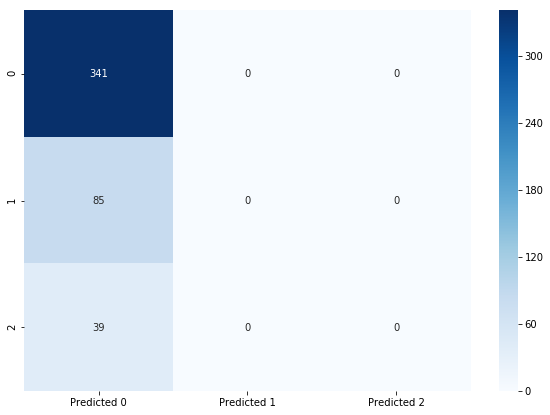

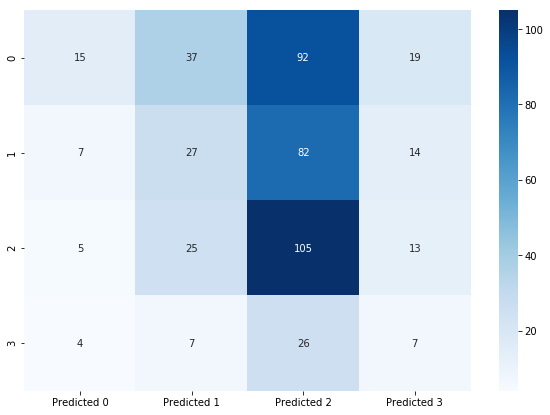

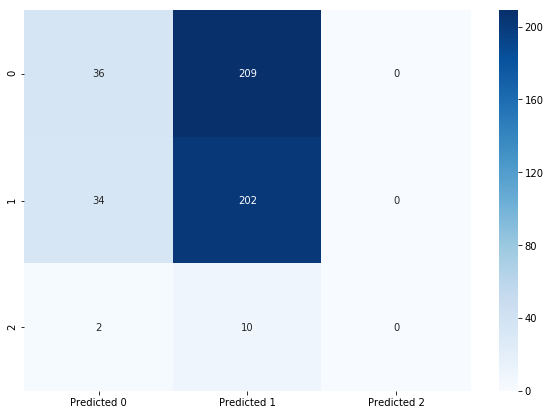

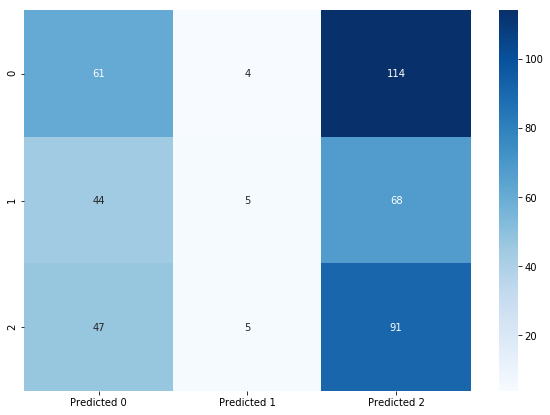

In [14]:
allModels = trainAll(xy)

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

In [16]:
# SVG(model_to_dot(allModels[2], show_shapes=True).create(prog='dot', format='svg'))
plot_model(allModels[0], to_file='model.png')

In [17]:
allModels[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 66,947
Trainable params: 66,947
Non-trainable params: 0
_________________________________________________________________


In [18]:
!pwd

/media/Vincent/Dropbox/Markov/code
